Generación de etiquetas con label studio. Para ello primero es necesario convertir la simagenes -.tiff a .png que es compatible con label studio
# Conversion .tiff -> .png

In [2]:
import cv2
import os

def convert_tiff_to_png(input_dir, output_dir):
    # Check if output directory exists, create if not
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all files in the input directory
    for filename in os.listdir(input_dir):
        # Only process TIFF files
        if filename.lower().endswith('.tiff') or filename.lower().endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            
            # Read the TIFF image
            img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            
            if img is None:
                print(f"Error reading {filename}")
                continue

            # Construct the output filename (replace .tiff or .tif with .png)
            output_filename = os.path.splitext(filename)[0] + '.png'
            output_path = os.path.join(output_dir, output_filename)
            
            # Save the image as PNG
            cv2.imwrite(output_path, img)
            print(f"Converted {filename} to {output_filename}")

if __name__ == "__main__":
    basedir = "D:/Universidad/MsC/VA/proyecto curso/database/test"
    input_directory = basedir
    output_directory = f"{basedir}/png"
    
    convert_tiff_to_png(input_directory, output_directory)


Converted database_batch__1.tif to database_batch__1.png
Converted database_batch__14.tif to database_batch__14.png
Converted database_batch__16.tif to database_batch__16.png
Converted database_batch__17.tif to database_batch__17.png
Converted database_batch__20.tif to database_batch__20.png
Converted database_batch__4.tif to database_batch__4.png
Converted database_batch__5.tif to database_batch__5.png
Converted database_batch__7.tif to database_batch__7.png
Converted database_batch__9.tif to database_batch__9.png


Ahora vamos a importar unas anotaciones ya hechas con Label-studio y modificarlas para que encajen con otro proyecto

primero, importa las etiquetas en un archivo json y exploremos su estructura

# Importar Json

In [2]:
import json
import os
from typing import List, Dict
import pandas as pd

# Ruta del archivo JSON 
archivo_json = "D:/Universidad/MsC/VA/proyecto curso/json labels/HR_imgs_17_20__partial_16.json"

# Función para leer y extraer información clave
def analizar_estructura(json_data: List[Dict]) -> List[Dict]:
    resumen = []
    for tarea in json_data:
        task_id = tarea.get("id")
        project = tarea.get("project")
        file_upload = tarea.get("file_upload")
        ruta_imagen = tarea.get("data", {}).get("image")
        inner_id = tarea.get("inner_id")
        for anotacion in tarea.get("annotations", []):
            annotation_id = anotacion.get("id")
            etiquetas = []
            for result in anotacion.get("result", []):
                etiqueta = {
                    "etiqueta": result["value"]["rectanglelabels"][0] if result["value"].get("rectanglelabels") else None,
                    "x": result["value"].get("x"),
                    "y": result["value"].get("y"),
                    "width": result["value"].get("width"),
                    "height": result["value"].get("height")
                }
                etiquetas.append(etiqueta)
            resumen.append({
                "task_id": task_id,
                "annotation_id": annotation_id,
                "project_id": project,
                "file_upload": file_upload,
                "ruta_imagen": ruta_imagen,
                "inner_id": inner_id,
                "etiquetas": etiquetas
            })
    return resumen

# Leer el archivo y analizar
with open(archivo_json, 'r') as f:
    datos = json.load(f)

resumen_datos = analizar_estructura(datos)

# Crear DataFrame de resumen
df_resumen = pd.json_normalize(resumen_datos, 'etiquetas', 
                               ['task_id', 'annotation_id', 'project_id', 'file_upload', 'ruta_imagen', 'inner_id'])



## Transformación entre proyectos
Ahora modificamos la parte de la estructura que nos interesa

In [3]:
import json
import copy

# Ruta del archivo original
archivo_json = "D:/Universidad/MsC/VA/proyecto curso/json labels/HR_imgs_17_20__partial_16.json"

# Leer los datos originales
with open(archivo_json, 'r') as f:
    datos = json.load(f)

# Copiamos los datos originales para modificarlos sin sobrescribir
datos_modificados = copy.deepcopy(datos)

# --- Configuración del usuario para modificación de JSON ---

# Nuevo ID de proyecto
nuevo_project_id = 8

# Mapeo de task_id originales a nuevos valores deseados
modificaciones = {
    16: {
        "nuevo_task_id": 44,
        "nuevo_annotation_id": 17,
        "nuevo_inner_id": 7,
        "nuevo_file_upload": "2b736095-database_batch_HR_16.png"
    },
    17: {
        "nuevo_task_id": 45,
        "nuevo_annotation_id": 18,
        "nuevo_inner_id": 8,
        "nuevo_file_upload": "121bfe99-database_batch_HR_17.png"
    },
    20: {
        "nuevo_task_id": 46,
        "nuevo_annotation_id": 19,
        "nuevo_inner_id": 9,
        "nuevo_file_upload": "5bda91c8-database_batch_HR_20.png"
    }
}

# Aplicar modificaciones
for tarea in datos_modificados:
    task_id_original = tarea["id"]
    if task_id_original in modificaciones:
        cambio = modificaciones[task_id_original]

        # Modificar campos principales
        tarea["id"] = cambio["nuevo_task_id"]
        tarea["inner_id"] = cambio["nuevo_inner_id"]
        tarea["project"] = nuevo_project_id
        tarea["file_upload"] = cambio["nuevo_file_upload"]
        nueva_ruta = f"/data/upload/{nuevo_project_id}/{cambio['nuevo_file_upload']}"
        tarea["data"]["image"] = nueva_ruta

        # Modificar anotaciones
        for anotacion in tarea.get("annotations", []):
            anotacion["id"] = cambio["nuevo_annotation_id"]
            anotacion["task"] = cambio["nuevo_task_id"]
            anotacion["project"] = nuevo_project_id

# Guardar resultado como nuevo archivo
archivo_salida = "D:/Universidad/MsC/VA/proyecto curso/json labels/for_project8_img_16_17_20.json"
with open(archivo_salida, 'w') as f_out:
    json.dump(datos_modificados, f_out, indent=2)

archivo_salida


'D:/Universidad/MsC/VA/proyecto curso/json labels/for_project8_img_16_17_20.json'

In [4]:
import json
import copy

# Ruta del archivo original
archivo_json = "D:/Universidad/MsC/VA/proyecto curso/json labels/imgs_16_14_danny.json"

# Leer los datos originales
with open(archivo_json, 'r') as f:
    datos = json.load(f)

# Copiamos los datos originales para modificarlos sin sobrescribir
datos_modificados = copy.deepcopy(datos)

# --- Configuración del usuario para modificación de JSON ---

# Nuevo ID de proyecto
nuevo_project_id = 8

# Mapeo de task_id originales a nuevos valores deseados
modificaciones = {
    1: {
        "nuevo_task_id": 44,
        "nuevo_annotation_id": 17,
        "nuevo_inner_id": 7,
        "nuevo_file_upload": "2b736095-database_batch_HR_16.png"
    },
    3: {
        "nuevo_task_id": 45,
        "nuevo_annotation_id": 18,
        "nuevo_inner_id": 8,
        "nuevo_file_upload": "7e1df293-database_batch_HR_14.png"
    }
}

# Aplicar modificaciones
for tarea in datos_modificados:
    task_id_original = tarea["id"]
    if task_id_original in modificaciones:
        cambio = modificaciones[task_id_original]

        # Modificar campos principales
        tarea["id"] = cambio["nuevo_task_id"]
        tarea["inner_id"] = cambio["nuevo_inner_id"]
        tarea["project"] = nuevo_project_id
        tarea["file_upload"] = cambio["nuevo_file_upload"]
        nueva_ruta = f"/data/upload/{nuevo_project_id}/{cambio['nuevo_file_upload']}"
        tarea["data"]["image"] = nueva_ruta

        # Modificar anotaciones
        for anotacion in tarea.get("annotations", []):
            anotacion["id"] = cambio["nuevo_annotation_id"]
            anotacion["task"] = cambio["nuevo_task_id"]
            anotacion["project"] = nuevo_project_id

# Guardar resultado como nuevo archivo
archivo_salida = "D:/Universidad/MsC/VA/proyecto curso/json labels/for_project8_img_16_14.json"
with open(archivo_salida, 'w') as f_out:
    json.dump(datos_modificados, f_out, indent=2)

archivo_salida


'D:/Universidad/MsC/VA/proyecto curso/json labels/for_project8_img_16_14.json'

## Conversión Json a CSV

In [ ]:
import pandas as pd
import json
import os

# Cargar el archivo JSON modificado anteriormente
archivo_json = "D:/Universidad/MsC/VA/proyecto curso/json labels/project-8-at-2025-05-30-13-19-all images.json"
with open(archivo_json, 'r') as f:
    data = json.load(f)

# Lista para guardar las filas del CSV
csv_rows = []

for tarea in data:
    #ruta = tarea["data"]["image"]  # ejemplo: /data/upload/99/0a85a39e-database_batch_HR_1.png
    #file_upload = tarea["file_upload"]  # ejemplo: 0a85a39e-database_batch_HR_1.png
    file_upload = tarea["data"]["image"]

    # Normalizar nombre de imagen: eliminar lo anterior al guion
    if '-' in file_upload:
        nombre_normalizado = file_upload.split('-', 1)[1]
    else:
        nombre_normalizado = file_upload

    for anotacion in tarea.get("annotations", []):
        for result in anotacion.get("result", []):
            value = result.get("value", {})
            if result["type"] == "rectanglelabels":
                label = value["rectanglelabels"][0] if value.get("rectanglelabels") else None
                xmin = value["x"]
                ymin = value["y"]
                width = value["width"]
                height = value["height"]
                # Comentar si no se necesitan las coordenadas porcentuales
                xmax = xmin + width
                ymax = ymin + height
                orig_w = result.get("original_width")
                orig_h = result.get("original_height")

                # Convertir de píxles absolutos a porcentuales
                #xmin_pct = (xmin / orig_w) * 100 if orig_w else 0
                #ymin_pct = (ymin / orig_h) * 100 if orig_h else 0
                #xmax_pct = ((xmin + width) / orig_w) * 100 if orig_w else 0
                #ymax_pct = ((ymin + height) / orig_h) * 100 if orig_h else 0


                csv_rows.append({
                    "image_path": nombre_normalizado,
                    "xmin": xmin, #xmin_pct,
                    "ymin": ymin, #ymin_pct,
                    "xmax": xmax, #xmax_pct,
                    "ymax": ymax, #ymax_pct,
                    "label": label
                })




In [9]:
import json
import pandas as pd

def json_2_df(
    archivo_json: str
):
    """
    Exporta anotaciones de bounding boxes desde un JSON de Label Studio a un Dataframe de Pandas,
    con etiquetas normalizadas a coordenadas entre 0 y 100 (porcentuales).

    Parámetros:
    - archivo_json (str): Ruta al archivo JSON de Label Studio.

    Retorna:
    - pd.DataFrame con las anotaciones exportadas con columnas 'image_path,xmin,ymin,xmax,ymax,label'.
    """

    # Cargar JSON
    with open(archivo_json, 'r') as f:
        data = json.load(f)

    csv_rows = []

    for tarea in data:
        file_upload = tarea["data"]["image"]

        # Normalizar nombre del archivo eliminando el prefijo hasta el primer guion
        if '-' in file_upload:
            nombre_normalizado = file_upload.split('-', 1)[1]
        else:
            nombre_normalizado = file_upload

        for anotacion in tarea.get("annotations", []):
            for result in anotacion.get("result", []):
                if result["type"] != "rectanglelabels":
                    continue  # Ignorar otros tipos de anotaciones

                value = result.get("value", {})
                label = value["rectanglelabels"][0] if value.get("rectanglelabels") else None

                xmin = value["x"]
                ymin = value["y"]
                width = value["width"]
                height = value["height"]
                xmax = xmin + width
                ymax = ymin + height

                csv_rows.append({
                    "image_path": nombre_normalizado,
                    "xmin": xmin, 
                    "ymin": ymin, 
                    "xmax": xmax, 
                    "ymax": ymax, 
                    "label": label
                })

    return pd.DataFrame(csv_rows)


In [ ]:
# Exportar DataFrame a CSV
csv_output_path = "/mnt/data/anotaciones_label_studio.csv"

# Exportar en coordenadas porcetuales
df_prc = json_2_df(
    archivo_json="D:/ruta/a/tu_json.json")
df_prc.to_csv(csv_output_path, index=False)


# Json a ShapeFile

In [16]:
# Importar librerías necesarias
import os
import json
import pandas as pd
import rasterio
from shapely.geometry import box
import geopandas as gpd

# --- Rutas y Nombres de Archivo ---
LABELS_FOLDER =  "D:/Universidad/MsC/VA/proyecto curso/json labels/"
IMAGES_FOLDER = "D:/Universidad/MsC/VA/proyecto curso/database/test/tif_1x_res/"
OUTPUT_FOLDER = "D:/Universidad/MsC/VA/proyecto curso/json labels/"
LABELS_JSON_FILENAME = "project-8-at-2025-06-02-17-25-all_images.json"
OUTPUT_SHAPEFILE_NAME = 'test_labels.shp'

# Convertir JSON a DataFrame
df = json_2_df(
    archivo_json=os.path.join(LABELS_FOLDER, LABELS_JSON_FILENAME))

# Lista con el mapelo de nombres de imágenes
image_mapping = {
    'database_batch_HR_1.png': 'database_batch_1.tif',
    'database_batch_HR_4.png': 'database_batch_4.tif',
    'database_batch_HR_5.png': 'database_batch_5.tif',
    'database_batch_HR_7.png': 'database_batch_7.tif',
    'database_batch_HR_9.png': 'database_batch_9.tif',
    'database_batch_HR_14.png': 'database_batch_14.tif',
    'database_batch_HR_16.png': 'database_batch_16.tif',
    'database_batch_HR_17.png': 'database_batch_17.tif',
    'database_batch_HR_20.png': 'database_batch_20.tif'}

# Cambiar los nombres de las imágenes en el DataFrame
df['image_path'] = df['image_path'].map(image_mapping)

# Cambiar las etiquetas lemon a Lemon
df['label'] = df['label'].replace('lemon', 'Lemon')


## Visualizar boxes

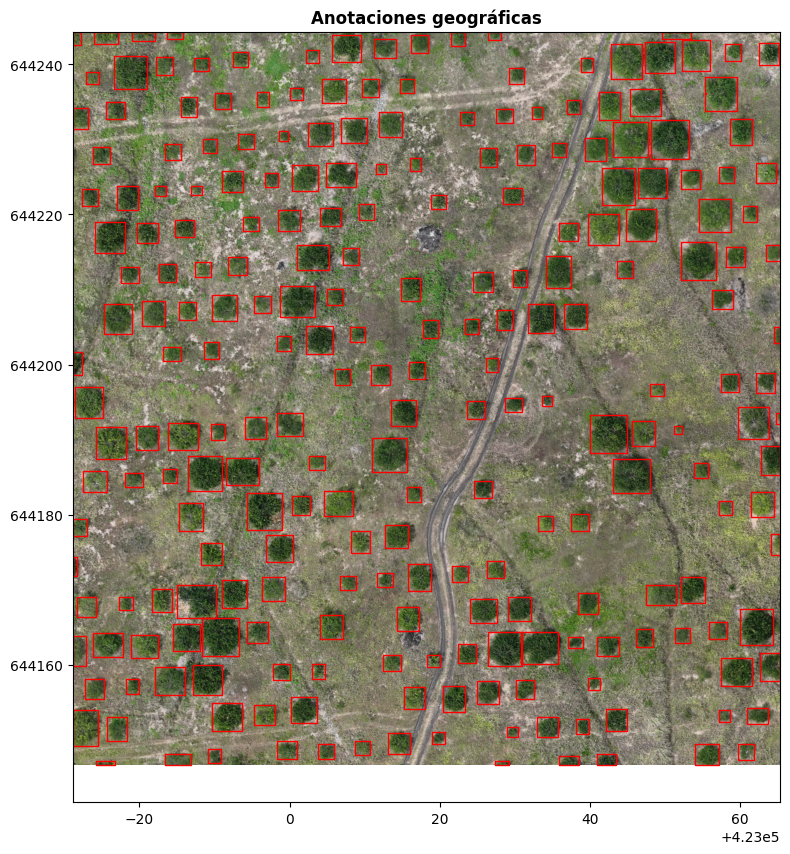

In [19]:
import rasterio
from shapely.geometry import box
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rasterio.plot


def visualizar_boxes_geograficos(df: pd.DataFrame, ruta_tif: str, image_column: str = "image_path"):
    """
    Convierte bounding boxes en coordenadas geográficas y los visualiza sobre la imagen GeoTIFF.
    
    Parámetros:
    - df: DataFrame con columnas xmin, ymin, xmax, ymax
    - ruta_tif: ruta al archivo GeoTIFF
    - image_column: columna del DataFrame con nombre del archivo tif (opcional si es único)
    """

    # Abrimos el .tif original
    with rasterio.open(ruta_tif) as src:
        transform = src.transform
        crs = src.crs
        image = src.read(1)  # solo una banda para visualizar
        orig_w = image.shape[1]
        orig_h = image.shape[0]

        geoms = []
        for _, row in df.iterrows():
            # Coordenadas porcentuales
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

            # Convertir a coordenadas de píxeles
            # Convertir a píxeles
            xmin = (xmin / 100) * orig_w
            ymin = (ymin / 100) * orig_h
            xmax = (xmax / 100) * orig_w
            ymax = (ymax / 100) * orig_h
            # Convertir a coordenadas geográficas (esquina sup-izq e inf-der)
            # rasterio usa (col, row)
            lon_min, lat_min = rasterio.transform.xy(transform, ymin, xmin, offset='ul')
            lon_max, lat_max = rasterio.transform.xy(transform, ymax, xmax, offset='lr')

            # Crear polígono
            geom = box(lon_min, lat_max, lon_max, lat_min)
            geoms.append(geom)

        # Crear GeoDataFrame
        gdf = gpd.GeoDataFrame(df.copy(), geometry=geoms, crs=crs)

        # Plot
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title("Bounding boxes en coordenadas geográficas")
        rasterio.plot.show(src, ax=ax, title="Anotaciones geográficas")
        gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=1, cmap='Set1', label='Bounding Boxes')
        plt.show()

    return gdf

# Tomar la primera imagen del directorio de imágenes
ruta_tif = os.path.join(IMAGES_FOLDER, 'database_batch_1.tif')

# Tomar las anotaciones correspondientes a esa imagen
df_image = df[df['image_path'] == 'database_batch_1.tif']

# Visualizar las bounding boxes geográficas
gdf_boxes = visualizar_boxes_geograficos(df_image, ruta_tif)

## Exportar a shapefile

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import rasterio
from pathlib import Path

def exportar_anotaciones_shapefile(df, carpeta_tifs, salida_shp):
    """
    Exporta anotaciones de bounding boxes desde un DataFrame a un Shapefile,
    convirtiendo las coordenadas de píxeles a coordenadas geográficas.
    """
    geometries = []
    registros = []

    for imagen, df_img in df.groupby("image_path"):
        ruta_tif = Path(carpeta_tifs) / imagen
        if not ruta_tif.exists():
            print(f"⚠️ Imagen no encontrada: {ruta_tif}")
            continue

        with rasterio.open(ruta_tif) as src:
            transform = src.transform
            crs = src.crs
            image = src.read(1)  # solo una banda para visualizar
            width = image.shape[1]
            height = image.shape[0]

            for _, row in df_img.iterrows():
                # Normalizados (0-100), convertir a pixeles
                xmin = (row['xmin'] / 100) * width
                ymin = (row['ymin'] / 100) * height
                xmax = (row['xmax'] / 100) * width
                ymax = (row['ymax'] / 100) * height

                # Convertir a coordenadas geográficas
                lon_min, lat_min = rasterio.transform.xy(transform, ymin, xmin, offset='ul')
                lon_max, lat_max = rasterio.transform.xy(transform, ymax, xmax, offset='lr')

                poly = box(lon_min, lat_max, lon_max, lat_min)
                geometries.append(poly)

                registros.append({
                    "image": imagen,
                    "label": row["label"]
                })

    # Crear GeoDataFrame
    gdf = gpd.GeoDataFrame(registros, geometry=geometries, crs=crs)

    # Exportar a Shapefile
    gdf.to_file(salida_shp)
    print(f"✅ Exportado a: {salida_shp}")
    return gdf

gdf = exportar_anotaciones_shapefile(
    df,
    carpeta_tifs= IMAGES_FOLDER,
    salida_shp= os.path.join(OUTPUT_FOLDER, LABELS_JSON_FILENAME)
)

✅ Exportado a: D:/Universidad/MsC/VA/proyecto curso/json labels/proveedor_labels.shp


# Estadisticas de las etiquetas